In [4]:
import os
import pickle
import sys
import time
import glob
import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np

import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch import sigmoid

from lucent.util import set_seed
from lucent.modelzoo import vgg19, util
from helper import smoothing_laplacian_loss, sparsity_loss

#################################
from cadena_model_cnn import ConvNet

#################################

import tqdm

roi_name   = sys.argv[1]
layer      = sys.argv[2]

if len(sys.argv) == 4:
    device_gpu = int(sys.argv[3])

roi_name = '3'
layer    = 10
print('\nROI:  ', roi_name, '\nLayer:  ', layer)


if os.name == 'posix':   #When it runs ar donders
    data_filename  = '/home/jose/Desktop/Data/data_THINGS_array'+ roi_name +'_v1_cnn.pkl'
if os.name == 'nt':      #When it runs at NINs
    data_filename  = 'E:/Jose/Data/data_THINGS_array'+ roi_name +'_v1.pkl'

device = 'cuda:0'

print(' \n\n\nLoading data')
# load data
f = open(data_filename,"rb")
cc = pickle.load(f)
train_data = cc['train_data']
val_data = cc['val_data']
img_data = cc['img_data']
val_img_data = cc['val_img_data']
n_neurons = train_data.shape[1]
print('\n\nData Loaded\n\n')

in_channels  = [3, 32, 32]
out_channels = [32,32,32]
kernel_sizes = [13,3, 3]
n_neurons = train_data.shape[1]



net = ConvNet(in_channels, out_channels, kernel_sizes, n_neurons=n_neurons)

for i in net.parameters(): 
    #print(i)
    print(type(i))
    print(i.shape)\

import itertools
list(itertools.chain.from_iterable([list(i.parameters()) for i in net.conv_layers]))

##########
#lr = 1e-6
#epochs = 20
#batch_size = 50

train_dataset_size = img_data.shape[0]
val_dataset_size   = val_img_data.shape[0]

#smooth_weight = 0.1
#sparse_weight = 1e-2
##########

for i in range(len(net.conv_layers)):
    print(i)
    print(list(net.conv_layers[i].parameters())[0].is_leaf)
    print(list(net.conv_layers[i].parameters())[1].is_leaf)

print('W features: ', net.w_features.is_leaf)
print('W spatial: ', net.w_spatial.is_leaf)

transform = transforms.Compose([transforms.Resize(40),
                                #transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])

img_data       = transform(img_data).to(device)
train_data     = torch.tensor(train_data).to(device)

val_img_data  = transform(val_img_data).to(device)
val_data      = torch.tensor(val_data).to(device)

print(img_data.shape)
print(train_data.shape)
print(val_img_data.shape)
print(val_data.shape)


list_parameters = list(itertools.chain.from_iterable([list(i.parameters()) for i in net.conv_layers])) + [net.w_spatial, net.w_features]

# Explanation of this line of code ☝
#
# executing Adam([net.parameters()]) by itself was yielding and error:
#      TypeError: optimizer can only optimize Tensors, but one of the params is Module.parameters
# which I dont really understand why, since doing    for i in net.parameters(): print(i)
# shows all the parameters and their correct shapes, but anyway, it fails. So I will directly pass a list
# with the parameters, [net.w_features, net.w_spatial] is trivial. But for net.conv_layers it's a bit more complicated.
# What I do is iterate over layers and extract the parameters for each layer, but each layer has two parameters
# one with the filters, and then biases. So it returns a list, making it a list of lists. To make it flat it's possible
# to use itertools.chain.from_iterable to iterate the lists over the lists and extract it into 1d.
# A bit complex, but didn't work any other way.

criterion = torch.nn.MSELoss()

lr = 1e-9
optimizer = torch.optim.Adam(list_parameters, lr = lr)

print('\n\nEVERYTHING LOADED!!')


ROI:   3 
Layer:   10
 


Loading data


Data Loaded


Conv2d(3, 32, kernel_size=(13, 13), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
<class 'torch.nn.parameter.Parameter'>
torch.Size([576, 55])
<class 'torch.nn.parameter.Parameter'>
torch.Size([55, 1, 32])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32, 3, 13, 13])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'>
torch.Size([32])
0
True
True
1
True
True
2
True
True
W features:  True
W spatial:  True
torch.Size([22248, 3, 40, 40])
torch.Size([22248, 55])
torch.Size([100, 3, 40, 40])
torch.Size([100, 55])


EVERYTHING LOADED!!


In [5]:
##### Adding regularizations
#
# From the original paper:
# As in the original publication [40], we regularized the convolutional filters by imposing 
# smoothness constraints on the first layer and group sparseness on the subsequent layers
#

def smoothness_loss(weights): # Expecting something sim. [32, 3, 13, 13], can be seen in net.conv_layers[0].weight.shape
    # Smoothness filter values

    Laplacian = torch.tensor([[[0,-1,0],[-1,-4,-1],[0,-1,0]]])
    Laplacian_holder =torch.zeros([weights.shape[0], weights.shape[1],3,3])
    for filter_i, channel_i in itertools.product([i for i in range(weights.shape[0])], [i for i in range(weights.shape[1])]):
        Laplacian_holder[filter_i, channel_i, :, :] = Laplacian
    
    smoothness_loss = torch.sqrt(torch.sum(torch.square(torch.nn.functional.conv2d(weights, Laplacian_holder.cuda()))))
    return smoothness_loss
    
# smoothness_loss(net.conv_layers[0].weights)

##############################

def sparsity_loss(net):
    loss_holder = torch.zeros(len(net.conv_layers)-1)
    for i in range(1, len(net.conv_layers)):
        loss_holder[i-1] = torch.sum(torch.sqrt(torch.sum(torch.square(net.conv_layers[i].weight), dim = [2,3])))
    return torch.sum(loss_holder)

# sparsity_loss(net)

LR:   0.01
0


100%|██████████| 445/445 [03:04<00:00,  2.41it/s]


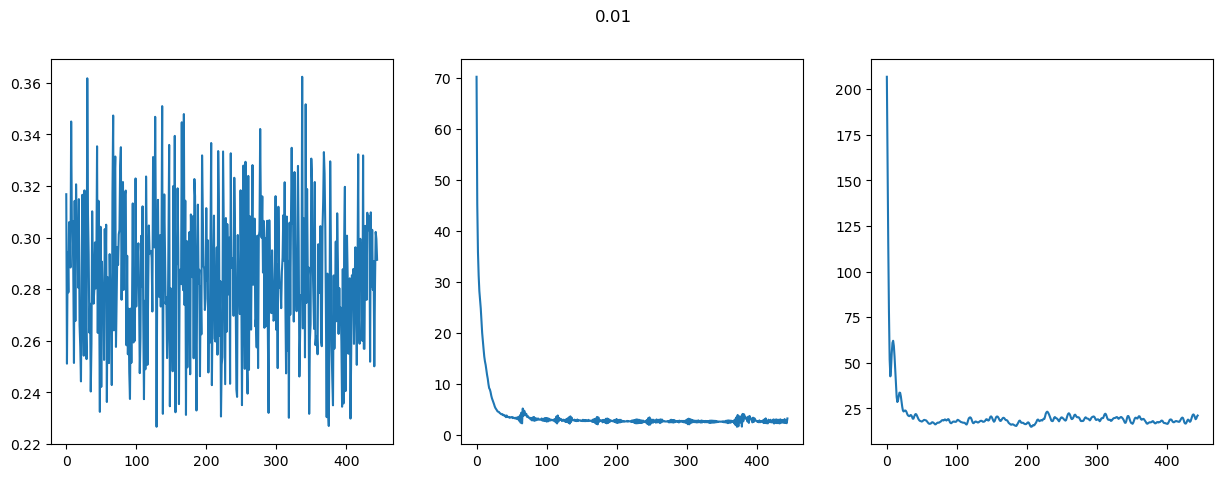

1


100%|██████████| 445/445 [03:05<00:00,  2.39it/s]


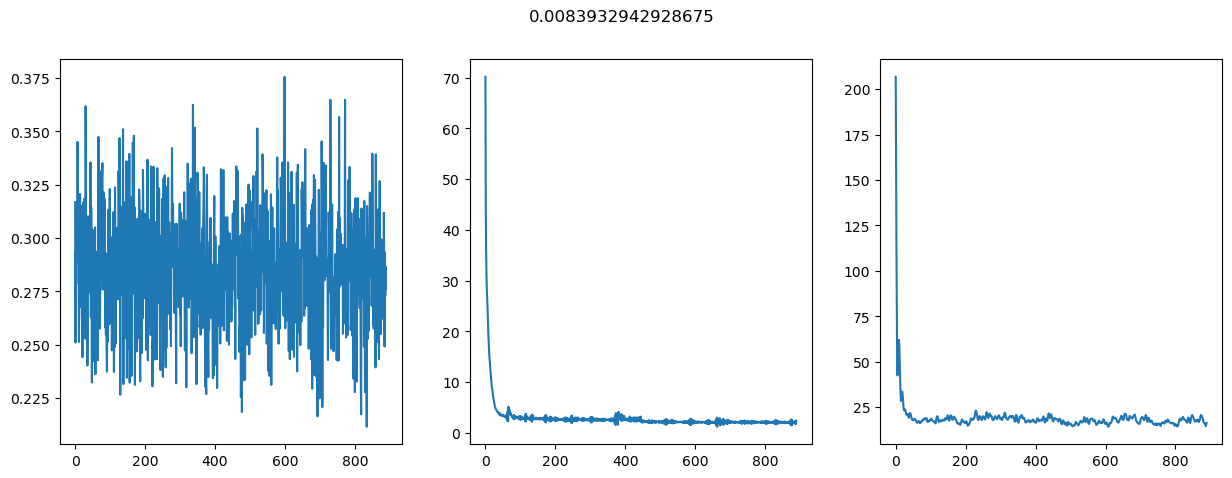

2


100%|██████████| 445/445 [03:07<00:00,  2.37it/s]


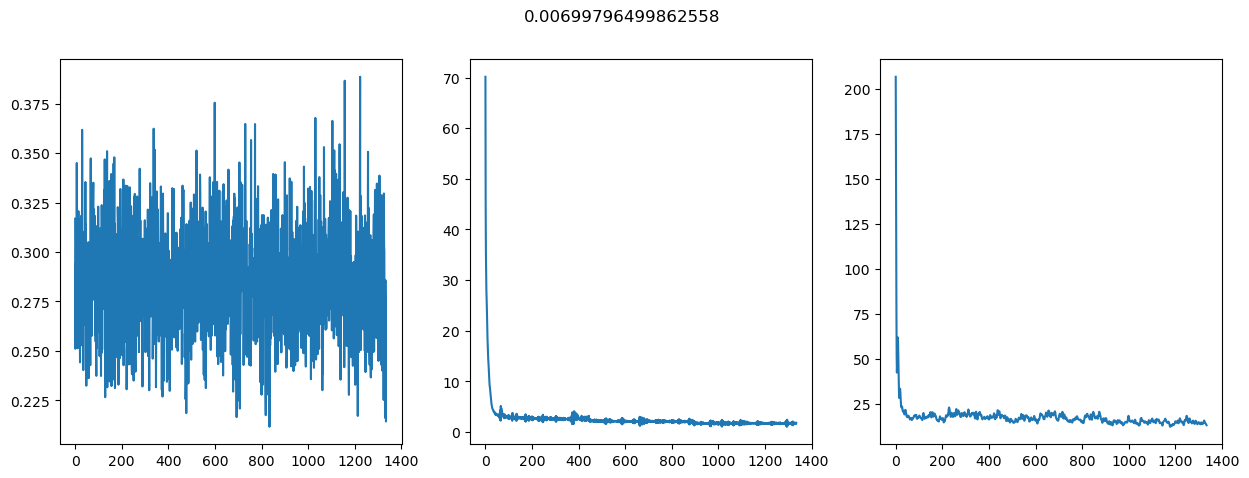

3


100%|██████████| 445/445 [03:03<00:00,  2.42it/s]


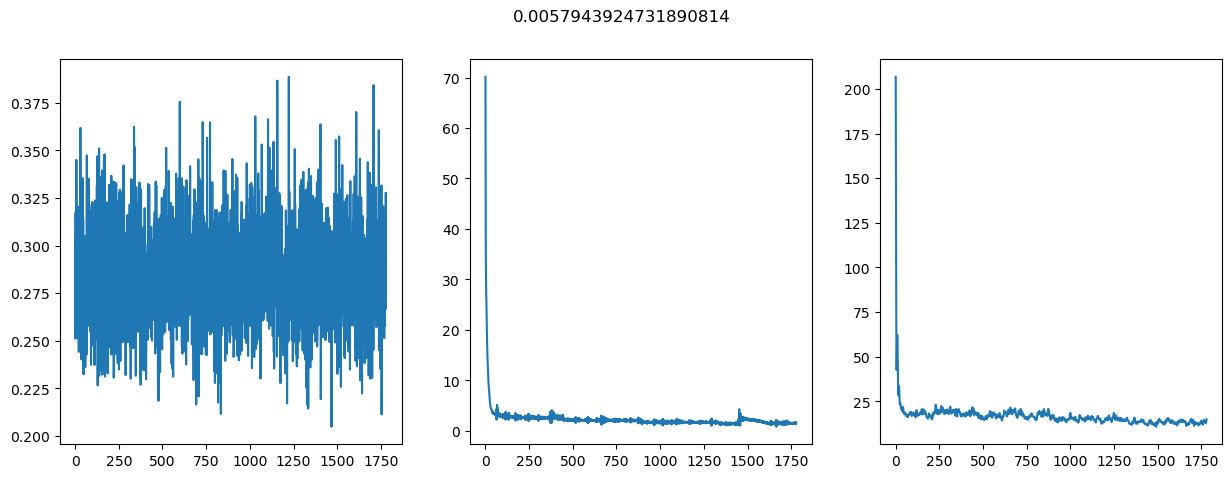

4


100%|██████████| 445/445 [03:05<00:00,  2.40it/s]


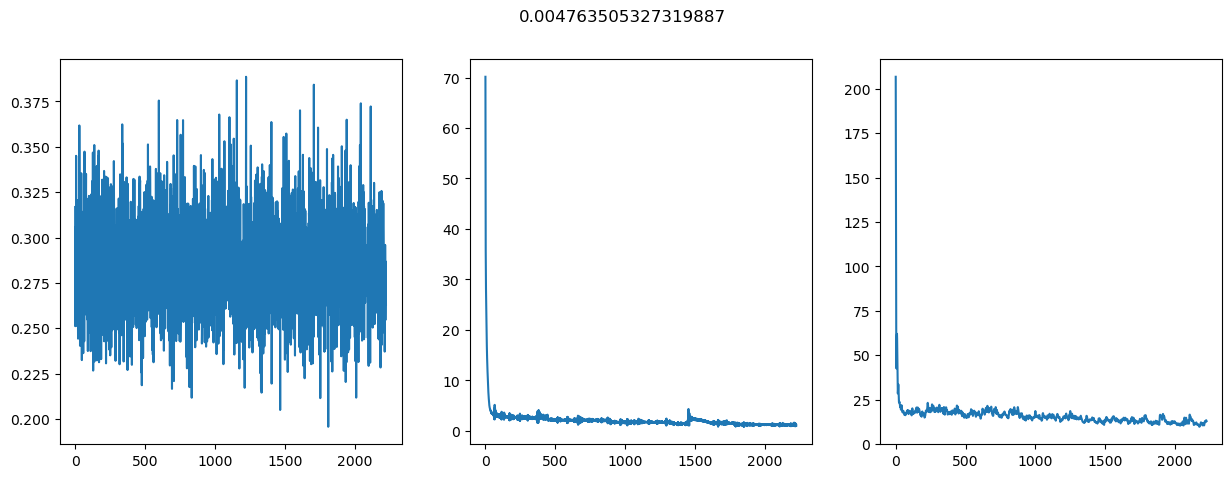

5


 63%|██████▎   | 281/445 [01:57<01:08,  2.39it/s]


KeyboardInterrupt: 

In [6]:
for i in range(2,3):
    lr = 10**-i

    print('LR:  ', 10**-i)

    loss_history         = []
    smoothness_loss_list = []
    sparsity_loss_list   = []


    optimizer = torch.optim.Adam(list_parameters, lr = lr)
    epochs = 50
    batch_size = 50


    for epoch in range(epochs):
        optimizer.param_groups[0]['lr'] = 10**-(2*np.exp(np.log(6)/48)**epoch)
        print(epoch)
        seen_idx = []
        permuted_idx = np.random.permutation(list(range(train_dataset_size)))
        
        for batch in tqdm.tqdm(range(int(train_dataset_size/batch_size)+1)):
            torch.cuda.empty_cache()
            batch_idx = permuted_idx[batch*batch_size:(batch+1)*batch_size]
            seen_idx.append(batch_idx)

            img_batch        = img_data[batch_idx,:].float()
            train_data_batch = train_data[batch_idx, :].float()

            outputs = net(img_batch).squeeze()

            #print(img_batch.type())
            #print(train_data_batch.type())
            #print('IMG_batch    ', img_batch.shape)
            #print('Train batch  ', train_data_batch.shape)
            #print('Outputs: ', outputs.shape)
            #print('\n\n\n\n')

            loss = criterion(outputs, train_data_batch)\
                + 0.001  * smoothness_loss(net.conv_layers[0].weight)\
                + 0.001 * sparsity_loss(net)

            with torch.no_grad():
                #print(criterion(outputs, train_data_batch).item())
                loss_history.append(criterion(outputs, train_data_batch).item())
                smoothness_loss_list.append(smoothness_loss(net.conv_layers[0].weight).item())
                sparsity_loss_list.append(sparsity_loss(net).item())

            #print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        f, ax = plt.subplots(1, 3, figsize = (15, 5))
        f.suptitle(str(optimizer.param_groups[0]['lr']))
        ax[0].plot(loss_history)
        ax[1].plot(smoothness_loss_list)
        ax[2].plot(sparsity_loss_list)
        plt.show()